In [5]:
! pip install torch_geometric

In [6]:
!  pip install blendertoolbox

In [7]:
! pip install bpy

In [8]:
python template.py

SyntaxError: invalid syntax (1304453204.py, line 1)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2



In [4]:
# Define the GNN Model
class ClothGNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ClothGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x



In [5]:
# Generate Cloth Data
def generate_cloth_data(num_points=30):
    points = np.array([[i, j, 0] for i in range(num_points) for j in range(num_points)], dtype=np.float32)
    edges = []
    for i in range(num_points):
        for j in range(num_points):
            if i < num_points - 1:
                edges.append([i * num_points + j, (i + 1) * num_points + j])
                edges.append([(i + 1) * num_points + j, i * num_points + j])
            if j < num_points - 1:
                edges.append([i * num_points + j, i * num_points + j + 1])
                edges.append([i * num_points + j + 1, i * num_points + j])
    edges = np.array(edges, dtype=np.int64).T
    return points, edges

points, edges = generate_cloth_data()
x = torch.tensor(points, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# Identify the indices of the fixed points (top-left and top-right corners)
fixed_points_indices = [0, 29]



In [6]:
# Initialize the model, optimizer, and loss function
model = ClothGNN(in_channels=3, out_channels=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the new bending loss function
def bending_loss_edge_length(output, edge_index, initial_lengths):
    current_lengths = torch.norm(output[edge_index[0]] - output[edge_index[1]], dim=1)
    deviation = torch.abs(current_lengths - initial_lengths)
    loss = torch.sum(deviation)
    return loss / edge_index.size(1)

initial_lengths = torch.norm(x[edge_index[0]] - x[edge_index[1]], dim=1)

# Placeholder for other loss functions
def collision_loss(output, min_dist=1.0):
    dist = torch.cdist(output, output, p=2)
    loss = torch.clamp(min_dist - dist, min=0)
    return loss.mean()

def inertia_loss(output, prev_output, velocity, dt=0.1):
    velocity = (output - prev_output) / dt
    expected_pos = prev_output + velocity * dt
    return nn.MSELoss()(output, expected_pos)

def gravity_loss(output, gravity_strength=9.81):
    return gravity_strength * output[:, 1].mean()

def wind_force(output, wind_strength=5.0):
    return wind_strength * output[:, 2].mean()

# Define the training function
prev_output = data.x.clone()
velocity = torch.zeros_like(data.x)

# Identify fixed points
fixed_points_indices = [0, 29]
timesteps_to_save = [0, 10, 20, 30, 40, 50, 60 ,70, 90, 100]
saved_outputs = []





In [7]:
def train(data, fixed_points_indices, initial_lengths, epochs=100):
    global prev_output, velocity
    model.train()
    frames = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        # Keep the positions of fixed points constant
        out = out.clone()
        out[fixed_points_indices] = data.x[fixed_points_indices]

        # Compute losses
        coll_loss = collision_loss(out)
        inert_loss = inertia_loss(out, prev_output, velocity)
        grav_loss = gravity_loss(out)
        bend_loss = bending_loss_edge_length(out, data.edge_index, initial_lengths)
        wind_loss = wind_force(out)

        # Ensure all losses are positive
        coll_loss = torch.abs(coll_loss)
        inert_loss = torch.abs(inert_loss)
        grav_loss = torch.abs(grav_loss)
        bend_loss = torch.abs(bend_loss)
        wind_loss = torch.abs(wind_loss)

        # Aggregate all losses into a single scalar value
        loss = coll_loss + inert_loss + grav_loss + bend_loss + wind_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update velocity and previous output
        velocity = out - prev_output
        prev_output = out.clone().detach()


        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss.item()}, Collision Loss: {coll_loss.item()}, Inertia Loss: {inert_loss.item()}, Gravity Loss: {grav_loss.item()}, Bending Loss: {bend_loss.item()}, Wind Loss: {wind_loss.item()}')

        # Store frames for the animation
        if epoch % 10 == 0:
            frame_path = visualize_cloth(data, model, epoch, fixed_points_indices, save=True)
            if frame_path:
                frames.append(frame_path)

    return frames



In [8]:
# Function to visualize the cloth at each timestep
def visualize_cloth(data, model, epoch, fixed_points_indices, save=False):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    out = model(data.x, data.edge_index).detach().numpy()
    
    # Plot cloth
    ax.scatter(out[:, 0], out[:, 1], out[:, 2], color='blue')
    for i in range(data.edge_index.shape[1]):
        start, end = out[data.edge_index[:, i]]
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2]], color='gray', alpha=0.5)
    
    # Ensure fixed points are plotted and not updated
    fixed_points = data.x[fixed_points_indices].detach().numpy()
    ax.scatter(fixed_points[:, 0], fixed_points[:, 1], fixed_points[:, 2], color='red', s=100)
    
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    ax.set_zlim(-15, 15)
    ax.set_title(f"Cloth Simulation at Epoch {epoch}")
     # Remove the axes
    ax.set_axis_off()

    # Save the frame if required
    if save:
        os.makedirs('frames', exist_ok=True)
        frame_path = f'frames/frame_{epoch:03d}.png'
        plt.savefig(frame_path)
        plt.close(fig)
        return frame_path
    else:
        plt.show()

# Train the model and get frames for animation
frames = train(data, fixed_points_indices, initial_lengths, epochs=100)

# Create a video from the frames using OpenCV# Create a video from the frames using OpenCV
def create_video(frames, output_filename='cloth_simulation.mp4', fps=10):
    frame_array = []
    for frame_path in frames:
        frame = cv2.imread(frame_path)
        height, width, layers = frame.shape
        size = (width, height)
        frame_array.append(frame)

    video = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for frame in frame_array:
        video.write(frame)
    video.release()

create_video(frames, output_filename='cloth_simulation.mp4', fps=10)

Epoch 0, Total Loss: 136.90158081054688, Collision Loss: 0.0021296103950589895, Inertia Loss: 4.1382633539539804e-13, Gravity Loss: 42.08705139160156, Bending Loss: 0.2914517819881439, Wind Loss: 94.52094268798828
Epoch 10, Total Loss: 31.285764694213867, Collision Loss: 0.002870074938982725, Inertia Loss: 3.0376549664317895e-16, Gravity Loss: 2.745887279510498, Bending Loss: 0.2788664400577545, Wind Loss: 28.258140563964844
Epoch 20, Total Loss: 16.953128814697266, Collision Loss: 0.004176062066107988, Inertia Loss: 5.731012513413408e-18, Gravity Loss: 2.0873985290527344, Bending Loss: 0.3735342025756836, Wind Loss: 14.488019943237305
Epoch 30, Total Loss: 10.02678108215332, Collision Loss: 0.0038289381191134453, Inertia Loss: 8.97044783397624e-18, Gravity Loss: 2.810154914855957, Bending Loss: 0.25546687841415405, Wind Loss: 6.957329750061035
Epoch 40, Total Loss: 7.33268404006958, Collision Loss: 0.00546432938426733, Inertia Loss: 3.66604875840338e-18, Gravity Loss: 3.15354609489440

In [16]:
def train(data, fixed_points_indices, epochs=100):
    global prev_output, velocity
    model.train()
    losses = {'total_loss': [], 'collision_loss': [], 'inertia_loss': [], 'gravity_loss': [], 'bending_loss': [], 'wind_loss': []}
    initial_lengths = torch.norm(data.x[data.edge_index[0]] - data.x[data.edge_index[1]], dim=1)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        # Keep the positions of fixed points constant
        out = out.clone()
        out[fixed_points_indices] = data.x[fixed_points_indices]

        # Compute losses
        coll_loss = collision_loss(out)
        inert_loss = inertia_loss(out, prev_output, velocity)
        grav_loss = gravity_loss(out)
        bend_loss = bending_loss_edge_length(out, data.edge_index, initial_lengths)
        wind_loss = wind_force(out)


        
        # Ensure all losses are positive
        coll_loss = torch.abs(coll_loss)
        inert_loss = torch.abs(inert_loss)
        grav_loss = torch.abs(grav_loss)
        bend_loss = torch.abs(bend_loss)
        wind_loss = torch.abs(wind_loss)

        # Aggregate all losses into a single scalar value
        loss = coll_loss + inert_loss + grav_loss + bend_loss + wind_loss

        # Backpropagation
        loss.backward()

        optimizer.step()

        # Update velocity and previous output
        velocity = out - prev_output
        prev_output = out.clone().detach()

        # Store losses
        losses['total_loss'].append(loss.item())
        losses['collision_loss'].append(coll_loss.item())
        losses['inertia_loss'].append(inert_loss.item())
        losses['gravity_loss'].append(grav_loss.item())
        losses['bending_loss'].append(bend_loss.item())
        losses['wind_loss'].append(wind_loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss.item()}, Collision Loss: {coll_loss.item()}, Inertia Loss: {inert_loss.item()}, Gravity Loss: {grav_loss.item()}, Bending Loss: {bend_loss.item()}, Wind Loss: {wind_loss.item()}')

    return losses
    

losses = train(data, fixed_points_indices, epochs= 100)

Epoch 0, Total Loss: 1.5991883277893066, Collision Loss: 0.006743621081113815, Inertia Loss: 9.332490726020286e-18, Gravity Loss: 0.8997583389282227, Bending Loss: 0.25981375575065613, Wind Loss: 0.43287259340286255
Epoch 10, Total Loss: 1.7105028629302979, Collision Loss: 0.006793948821723461, Inertia Loss: 1.3699175525326494e-17, Gravity Loss: 0.7699465751647949, Bending Loss: 0.24860748648643494, Wind Loss: 0.6851548552513123
Epoch 20, Total Loss: 1.6498876810073853, Collision Loss: 0.006719178520143032, Inertia Loss: 8.680042091701735e-18, Gravity Loss: 1.0966140031814575, Bending Loss: 0.23695029318332672, Wind Loss: 0.30960413813591003
Epoch 30, Total Loss: 2.13423490524292, Collision Loss: 0.00657421350479126, Inertia Loss: 1.6616401560025806e-19, Gravity Loss: 0.9330458641052246, Bending Loss: 0.22382767498493195, Wind Loss: 0.9707870483398438
Epoch 40, Total Loss: 1.681666374206543, Collision Loss: 0.006617478560656309, Inertia Loss: 1.7122363383800058e-19, Gravity Loss: 1.134

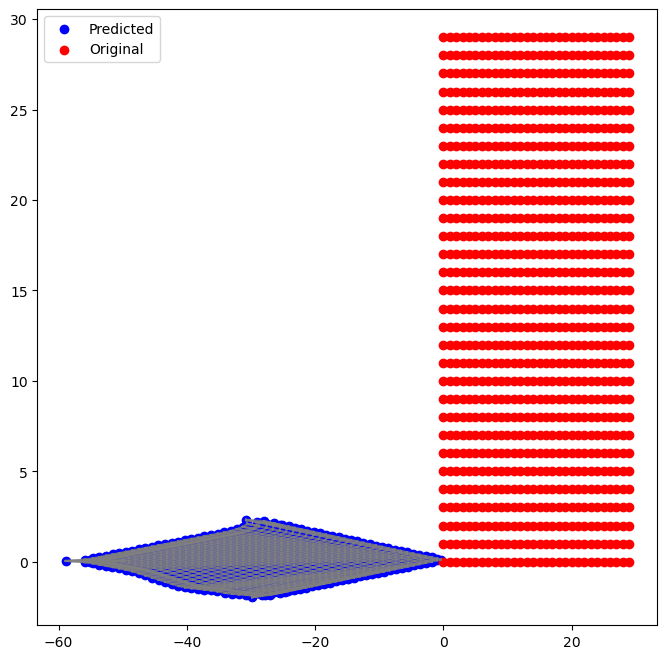

In [17]:
def visualize_cloth(data, timesteps_to_save, saved_outputs ):
    plt.figure(figsize=(8, 8))
    out = model(data.x, data.edge_index).detach().numpy()
    plt.scatter(out[:, 0], out[:, 1], color='blue', label='Predicted')
    plt.scatter(data.x[:, 0], data.x[:, 1], color='red', label='Original')
    for i in range(data.edge_index.shape[1]):
        plt.plot(out[data.edge_index[:, i], 0], out[data.edge_index[:, i], 1], color
                 ='gray', alpha=0.5)
    plt.legend()
    plt.show()

visualize_cloth(data,timesteps_to_save,  saved_outputs )

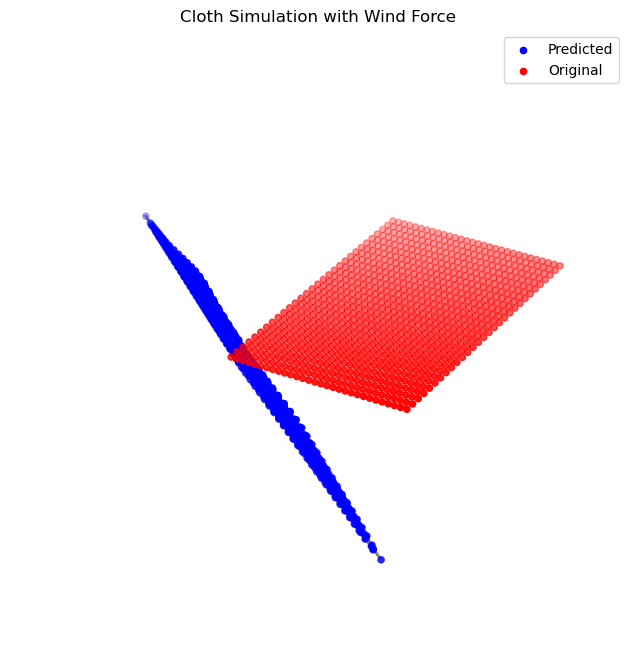

In [10]:
def visualize_cloth(data):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    out = model(data.x, data.edge_index).detach().numpy()
    ax.scatter(out[:, 0], out[:, 1], out[:, 2], color='blue', label='Predicted')
    ax.scatter(data.x[:, 0], data.x[:, 1], data.x[:,2],color='red', label='Original')
    for i in range(data.edge_index.shape[1]):
        ax.plot(out[data.edge_index[:, i], 0], out[data.edge_index[:, i], 1], out[data.edge_index[:, i], 2], color='gray', alpha=0.5)
    ax.legend()
    ax.set_title('Cloth Simulation with Wind Force')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_axis_off()
 
    plt.show()

visualize_cloth(data)

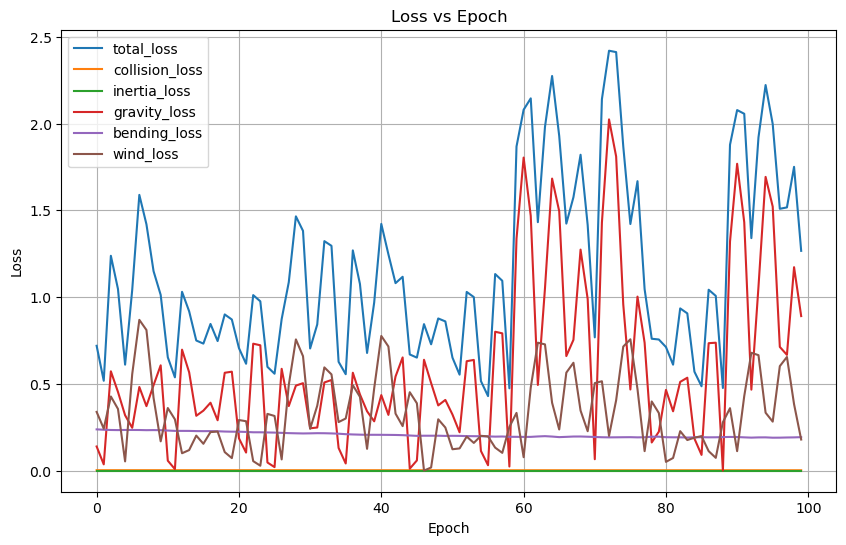

In [18]:
plt.figure(figsize=(10, 6))
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


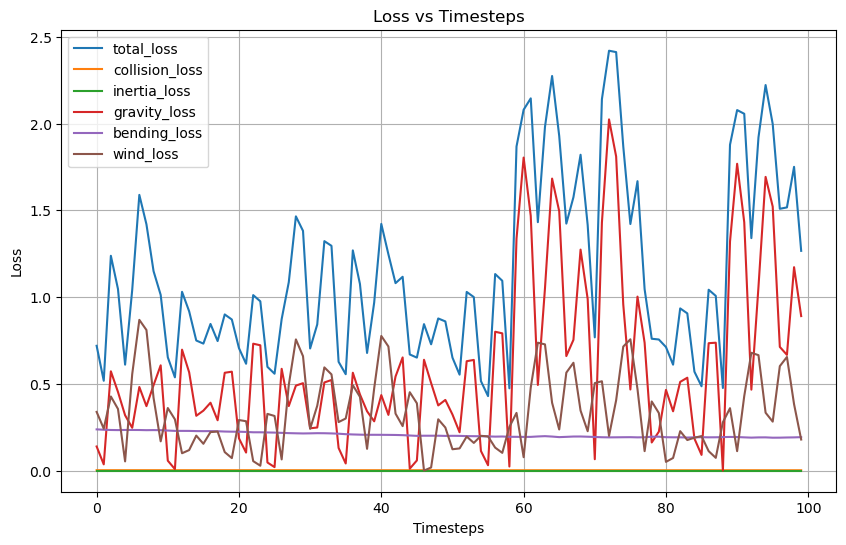

In [13]:
# Plot losses
plt.figure(figsize=(10, 6))
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.xlabel('Timesteps')
plt.ylabel('Loss')
plt.title('Loss vs Timesteps')
plt.legend()
plt.grid(True)
plt.show()
